In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import utils

device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda"

# Keep random number generator consistent
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Preprocess Data

In [2]:
from utils import get_sentences, get_vocabs, get_max_len_sentences

vocab_en = get_vocabs("vocab.en")
vocab_vi = get_vocabs("vocab.vi")

# Train sentences
train_sentences_en = get_sentences("train.en")
train_sentences_vi = get_sentences("train.vi")

# Actual test sentences
test_sentences_en = get_sentences("tst2013.en")
test_sentences_vi = get_sentences("tst2013.vi")

# Filter sentences over n words long, in this case 48
# The sentences will be n + 2 (50) words long when we include the <s>, </s> tokens
MAX_LEN = 48
MAX_LEN_WITH_TOKENS = 50

train_sentences_en, train_sentences_vi = get_max_len_sentences(train_sentences_en, train_sentences_vi, MAX_LEN)
test_sentences_en, test_sentences_vi = get_max_len_sentences(test_sentences_en, test_sentences_vi, MAX_LEN)

# Make validation sets
val_sentences_en = train_sentences_en[:int(len(train_sentences_en) * 0.1)]
val_sentences_vi = train_sentences_vi[:int(len(train_sentences_vi) * 0.1)]

# Update training sets
train_sentences_en = train_sentences_en[int(len(train_sentences_en) * 0.1):]
train_sentences_vi = train_sentences_vi[int(len(train_sentences_vi) * 0.1):]


In [3]:
len(train_sentences_en), len(train_sentences_vi)

(108748, 108748)

In [4]:
from torch.utils import data

PAD_INDEX = 0
UNK_INDEX = 1
SOS_INDEX = 2
EOS_INDEX = 3

class NMTDataset(data.Dataset):
    def __init__(self, source_sentences, source_vocabs, target_sentences, target_vocabs):
        self.max_sentence_length = MAX_LEN_WITH_TOKENS

        self.source_sentences = source_sentences[:int(len(source_sentences))]
        self.target_sentences = target_sentences[:int(len(source_sentences))]

        self.source_vocabs = source_vocabs
        self.target_vocabs = target_vocabs

        self.source_vocab_ids = {v : i for i, v in enumerate(source_vocabs)}
        self.source_id_to_vocabs = {val : key for key, val in self.source_vocab_ids.items()}
        self.target_vocab_ids = {v : i for i, v in enumerate(target_vocabs)}
        self.target_id_to_vocabs = {val : key for key, val in self.target_vocab_ids.items()}

    def __len__(self):
        return len(self.source_sentences)

    def __getitem__(self, index):
        source_sentence = self.source_sentences[index]
    
        # Add <s> and </s> to each source sentence
        source_len = len(source_sentence) + 2   
        source_id = []
        for w in source_sentence:
            if w not in self.source_vocabs:
                w = '<unk>'
            source_id.append(self.source_vocab_ids[w])

        source_id = ([SOS_INDEX] + source_id + [EOS_INDEX] + [PAD_INDEX] * (self.max_sentence_length - source_len))
        target_sentence = self.target_sentences[index]

        # Add <s> and </s> to each target sentence
        target_len = len(target_sentence) + 2
        target_id = []
        for w in target_sentence:
            if w not in self.target_vocabs:
                w = '<unk>'
            target_id.append(self.target_vocab_ids[w])

        target_id = ([SOS_INDEX] + target_id + [EOS_INDEX] + [PAD_INDEX] * (self.max_sentence_length - target_len))

        return torch.tensor(source_id), source_len, torch.tensor(target_id), target_len

## Baseline Encoder Decoder

In [5]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout = 0):
        super(Encoder, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first = True, dropout = dropout)
    
    def forward(self, inputs, lengths):       
        packed_inputs = pack_padded_sequence(inputs, lengths.detach().cpu(), batch_first=True, enforce_sorted=False)
        packed_outputs, hidden = self.rnn(packed_inputs)
        outputs, output_lengths = pad_packed_sequence(packed_outputs)
        
        return outputs, hidden

In [6]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout = 0):
        super(Decoder, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first = True, dropout = dropout)
        
        # Layer of how we connect the final encoder state as the start for the decoder
        self.encoder_to_decoder_layer = nn.Linear(hidden_size, hidden_size)
        
        self.dropout_layer = nn.Dropout(dropout)
        self.input_hidden_to_hidden_layer = nn.Linear(input_size + hidden_size, hidden_size, bias = False)
        
    def forward_step(self, prev_embed, hidden):
        # Does a single decoder step (one word)
        rnn_out, hidden_out = self.rnn(prev_embed, hidden)
        
        output = torch.cat([prev_embed, rnn_out], dim = 2)
        output = self.dropout_layer(output)
        output = self.input_hidden_to_hidden_layer(output)
        
        return rnn_out, hidden_out, output
        
    def forward(self, inputs, final_encoder_states, hidden = None, max_len = None):
        # Unroll the decoder one step at a time
        if max_len is None:
            max_len = inputs.size(1)
        if hidden is None:
            hidden = self.init_hidden(final_encoder_states)
            
        # Unrolling for decoder RNN for max_len steps
        decoder_states = []
        outputs = []
        for j in range(max_len):
            prev_embed = inputs[:, j].unsqueeze(1)
            rnn_out, hidden_out, output = self.forward_step(prev_embed, hidden)
            decoder_states.append(rnn_out)
            outputs.append(output)
        
        decoder_states = torch.cat(decoder_states, dim = 1)
        outputs = torch.cat(outputs, dim = 1)
        
        return hidden, outputs
            
    def init_hidden(self, final_encoder_states):
        # Initialize first decoder hidden state using the final encoder hidden states
        return torch.tanh(self.encoder_to_decoder_layer(final_encoder_states))
        
            

In [7]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, source_embed, target_embed, generator):
        super(EncoderDecoder, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.source_embed = source_embed
        self.target_embed = target_embed
        self.generator = generator
        
    def forward(self, source_ids, target_ids, source_lengths):
        encoder_hiddens, encoder_finals = self.encode(source_ids, source_lengths)
        return self.decode(encoder_finals, target_ids[:, :-1])

    def encode(self, source_ids, source_lengths):
        return self.encoder(self.source_embed(source_ids), source_lengths)

    def decode(self, final_encoder_states, target_ids, decoder_hidden=None):
        return self.decoder(self.target_embed(target_ids), final_encoder_states, decoder_hidden) 


In [8]:
class Generator(nn.Module):
    # Define standard linear and softmax generation step
    def __init__(self, hidden_size, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## Training 


In [9]:
import math

class LossCompute:
    def __init__(self, generator, criterion, opt = None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1))
        loss = loss / norm

        # Training mode
        if self.opt is not None:  
            loss.backward()          
            self.opt.step()
            self.opt.zero_grad()

        return loss.data.item() * norm

def run_epoch(data_loader, model, loss_compute, print_every):
    total_tokens = 0
    total_loss = 0

    for j, (source_ids_batch, source_lengths_batch, target_ids_batch, target_lengths_batch) in enumerate(data_loader):
        source_ids_batch = source_ids_batch.to(device)
        source_lengths_batch = source_lengths_batch.to(device)
        target_ids_batch = target_ids_batch.to(device)
        
        _, output = model(source_ids_batch, target_ids_batch, source_lengths_batch)

        loss = loss_compute(x = output, y = target_ids_batch[:, 1:], norm = source_ids_batch.size(0))
        total_loss += loss
        total_tokens += (target_ids_batch[:, 1:] != PAD_INDEX).data.sum().item()

        if model.training and j % print_every == 0:
              print("Epoch Step: {} Loss: {}".format(j, loss / source_ids_batch.size(0)))

    return math.exp(total_loss / float(total_tokens))

def train(model, num_epochs, learning_rate, print_every):
    # ignore_index as PAD_INDEX so that pad tokens won't be included when computing the loss
    criterion = nn.NLLLoss(reduction = "sum", ignore_index = PAD_INDEX)
    optim = torch.optim.Adam(model.parameters(), lr = learning_rate)

    # Keep track of dev perplexity for each epoch.
    dev_perplexities = []
    for epoch in range(num_epochs):
        print("Epoch", epoch)

        model.train()
        train_perplexity = run_epoch(data_loader = train_data_loader, model = model, loss_compute = LossCompute(model.generator, criterion, optim), print_every = print_every)
        
        model.eval()
        with torch.no_grad():      
            dev_perplexity = run_epoch(data_loader = val_data_loader, model = model, loss_compute = LossCompute(model.generator, criterion, None), print_every = print_every)
            print("Validation perplexity: {}".format(dev_perplexity))
            dev_perplexities.append(dev_perplexity)
        
    return dev_perplexities

## Baseline Encoder Decoder Training 

In [10]:
batch_size = 64

# Vietnamese to English
train_set = NMTDataset(train_sentences_vi, vocab_vi, train_sentences_en, vocab_en)
train_data_loader = data.DataLoader(train_set, batch_size = batch_size, num_workers = 2, shuffle=True)

val_set = NMTDataset(val_sentences_vi, vocab_vi, val_sentences_en, vocab_en)
val_data_loader = data.DataLoader(val_set, batch_size = batch_size, num_workers = 2, shuffle=False)

/home/nathgoh/anaconda3/envs/nlu/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Epoch 0
Epoch Step: 0 Loss: 157.0435791015625
Epoch Step: 100 Loss: 95.5426254272461
Epoch Step: 200 Loss: 97.3375473022461
Epoch Step: 300 Loss: 98.03572845458984
Epoch Step: 400 Loss: 96.92677307128906
Epoch Step: 500 Loss: 94.04923248291016
Epoch Step: 600 Loss: 90.77558135986328
Epoch Step: 700 Loss: 96.10883331298828
Epoch Step: 800 Loss: 83.01997375488281
Epoch Step: 900 Loss: 82.13379669189453
Epoch Step: 1000 Loss: 83.98336791992188
Epoch Step: 1100 Loss: 74.8805160522461
Epoch Step: 1200 Loss: 80.00877380371094
Epoch Step: 1300 Loss: 79.02659606933594
Epoch Step: 1400 Loss: 94.74223327636719
Epoch Step: 1500 Loss: 83.37337493896484
Epoch Step: 1600 Loss: 86.8

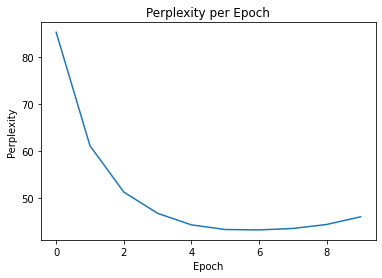

In [11]:
from utils import plot_perplexity

# Hyperparameters 
embed_size = 256   # Each word will be represented as a `embed_size`-dim vector.
hidden_size = 512  # RNN hidden size
dropout = 0.1

baseline_seq2seq = EncoderDecoder(
    encoder = Encoder(embed_size, hidden_size, dropout = dropout),
    decoder = Decoder(embed_size, hidden_size, dropout = dropout),
    source_embed = nn.Embedding(len(vocab_vi), embed_size),
    target_embed = nn.Embedding(len(vocab_en), embed_size),
    generator = Generator(hidden_size, len(vocab_en))).to(device)

train_model = True
if train_model:
    # Training, returns dev_perplexities, a list of dev perplexity for each epoch
    pure_dev_perplexities = train(baseline_seq2seq, num_epochs = 10, learning_rate = 0.0003, print_every = 100)
    torch.save(baseline_seq2seq.state_dict(), "baseline_seq2seq.pt")

    # Plot perplexity
    plot_perplexity(pure_dev_perplexities)
else:
    baseline_seq2seq.load_state_dict(torch.load("baseline_seq2seq.pt"))

In [12]:
baseline_seq2seq

EncoderDecoder(
  (encoder): Encoder(
    (rnn): GRU(256, 512, batch_first=True, dropout=0.1)
  )
  (decoder): Decoder(
    (rnn): GRU(256, 512, batch_first=True, dropout=0.1)
    (encoder_to_decoder_layer): Linear(in_features=512, out_features=512, bias=True)
    (dropout_layer): Dropout(p=0.1, inplace=False)
    (input_hidden_to_hidden_layer): Linear(in_features=768, out_features=512, bias=False)
  )
  (source_embed): Embedding(7710, 256)
  (target_embed): Embedding(17192, 256)
  (generator): Generator(
    (proj): Linear(in_features=512, out_features=17192, bias=False)
  )
)

## Baseline Decoding

In [13]:
def decode(model, source_ids, source_lengths, max_len):
    with torch.no_grad():
        hidden, final_encoder_states = model.encode(source_ids, source_lengths)
        prev_y = torch.ones(1, 1).fill_(SOS_INDEX).type_as(source_ids)

    output = []
    hidden = None
    for i in range(max_len):
        with torch.no_grad():
            _, outputs = model.decode(final_encoder_states, prev_y, hidden)
            prob = model.generator(outputs[:, -1])
            d, next_word = torch.max(prob, dim = 1)
            next_word = next_word.data.item()
            output.append(next_word)
            prev_y = torch.ones(1, 1).type_as(source_ids).fill_(next_word)
    output = np.array(output)

    EOS_mask = np.where(output == EOS_INDEX)
    if len(EOS_mask[0]) > 0:
        output = output[:EOS_mask[0][0]]

    return output

## Baseline Examples

In [14]:
from utils import lookup_words

def print_examples(model, source_vocab, target_vocab, data_loader, decoder, attention = False, n = 3, EOS_INDEX = 3, max_len = 50):

    model.eval()
        
    for j, (source_ids, source_lengths, target_ids, target_lengths) in enumerate(data_loader):
        if not attention:
            result = decoder(model, source_ids.to(device), source_lengths.to(device), max_len = max_len)
        else:
            result, _ = decoder(model, source_ids.to(device), source_lengths.to(device), max_len = max_len)

        # Remove <s>
        source_ids = source_ids[0, 1:]
        target_ids = target_ids[0, 1:]

        # Remove </s> and <pad>
        source_ids = source_ids[:np.where(source_ids == EOS_INDEX)[0][0]]
        target_ids = target_ids[:np.where(target_ids == EOS_INDEX)[0][0]]

        prediction = " ".join(utils.lookup_words(result, vocab = target_vocab))
        target = " ".join(utils.lookup_words(target_ids, vocab = target_vocab))
   
        print("Example {}".format(j + 1))
        print("Source : ", " ".join(lookup_words(source_ids, vocab = source_vocab)))
        print("Target : ", " ".join(lookup_words(target_ids, vocab = target_vocab)))
        print("Prediction: ", " ".join(lookup_words(result, vocab = target_vocab)))
        print()
        
        if j == n - 1:
            break

In [15]:
baseline_examples = NMTDataset(val_sentences_vi, vocab_vi, val_sentences_en, vocab_en)
baseline_example_data_loader = data.DataLoader(baseline_examples, batch_size = 1, num_workers = 1, shuffle = False)

print("Baseline Encoder-Decoder Results:")
print_examples(baseline_seq2seq, vocab_vi, vocab_en, baseline_example_data_loader, decode, n = 5)

Baseline Encoder-Decoder Results:
Example 1
Source :  Khoa học đằng sau một tiêu đề về khí hậu
Target :  Rachel <unk> : The science behind a climate headline
Prediction:  <unk> climate crisis .

Example 2
Source :  Tôi muốn cho các bạn biết về sự to lớn của những nỗ lực khoa học đã góp phần làm nên các dòng tít bạn thường thấy trên báo .
Target :  I &apos;d like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper .
Prediction:  I want to do .

Example 3
Source :  Có những dòng trông như thế này khi bàn về biến đổi khí hậu , và như thế này khi nói về chất lượng không khí hay khói bụi .
Target :  <unk> that look like this when they have to do with climate change , and headlines that look like this when they have to do with air quality or smog .
Prediction:  It &apos;s about the atmosphere , like this is like this is like this is like this is like this is like this is like this is like this is like this is like this is lik

## BLEU Testing


In [16]:
import sacrebleu

def compute_BLEU(model, data_loader, decoder, target_vocabs, attention = False):
  bleu_score = []

  model.eval()
  for source_ids, source_lengths, target_ids, _ in data_loader:
    if not attention:
      result = decoder(model, source_ids.to(device), source_lengths.to(device), max_len = MAX_LEN_WITH_TOKENS)
    else:
      result, _ = decoder(model, source_ids.to(device), source_lengths.to(device), max_len = MAX_LEN_WITH_TOKENS)

    # Remove <s>
    source_ids = source_ids[0, 1:]
    target_ids = target_ids[0, 1:]

    # Remove </s> and <pad>
    source_ids = source_ids[:np.where(source_ids == EOS_INDEX)[0][0]]
    target_ids = target_ids[:np.where(target_ids == EOS_INDEX)[0][0]]

    prediction = " ".join(utils.lookup_words(result, vocab=target_vocabs))
    target = " ".join(utils.lookup_words(target_ids, vocab=target_vocabs))

    bleu_score.append(sacrebleu.raw_corpus_bleu([prediction], [[target]], .01).score)

  return bleu_score

In [17]:
test_set = NMTDataset(test_sentences_vi, vocab_vi, test_sentences_en, vocab_en)
test_data_loader = data.DataLoader(test_set, batch_size = 1, num_workers = 2, shuffle = False)

print("BLEU score without Attention: {}".format(np.mean(compute_BLEU(baseline_seq2seq, test_data_loader, decode, vocab_en))))

BLEU score without Attention: 4.359142026146017
